In [63]:
from pyemma.msm import MaximumLikelihoodMSM

In [1]:
import pickle
from msmtools.estimation import transition_matrix as _transition_matrix
from msmtools.analysis import timescales as _timescales
from pyemma.util.metrics import vamp_score
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

This notebook tests some code for extracting timescale and vamp scores from the bootstrapped count matrices

In [31]:
def timescales(cmat, lag): 
    T = _transition_matrix(cmat, reversible=True)
    ts = _timescales(T, tau=lag)
    return ts
    

In [67]:
def vamp(cmat, T, method, k):

    C0t = cmat
    C00 = np.diag(C0t.sum(axis=1))
    Ctt = np.diag(C0t.sum(axis=0))
    return vamp_score(T, C00, C0t, Ctt, C00, C0t, Ctt,
                          k=k, score=method)
    

In [38]:
bs_paths = Path('scoring/2f4k/hp_0').glob('*.pkl')
bs_results = [pickle.load(path.open('rb')) for path in bs_paths]
vamp_ks = [2, 3, 4, 5, 6, 7, 8, 9, 10]
vamp_methods = ['VAMP1', 'VAMP2', 'VAMPE']

In [68]:


num_iters = len(bs_results)
num_lags = max([len(x['lags']) for x in bs_results])
num_vamp_ks  = len(vamp_ks)
num_vamp_methods = len(vamp_methods)
num_its = 10

all_timescales = np.empty((num_iters, num_lags, num_its))
all_vamps = np.empty((num_iters, num_lags, num_vamp_methods, num_vamp_ks))

for bs_idx in range(num_iters):
    results = bs_results[bs_idx]
    lags = results['lags']
    for lag_idx in range(len(lags)):
        lag = lags[lag_idx]
        
        cmat = results['count_matrices'][lag_idx]
        T = _transition_matrix(cmat, reversible=True)
        
        
        # accumulated timescales
        ts = _timescales(T, tau=lag)
        n_its= min(num_its, ts.shape[0])
        all_timescales[bs_idx, lag_idx][:n_its] = ts[1:n_its+1]
        
        for meth_idx, method in enumerate(vamp_methods):
            for k_idx, k in enumerate(vamp_ks):
                all_vamps[bs_idx, lag_idx, meth_idx, k_idx] = vamp(cmat, T, method, k)
                
                


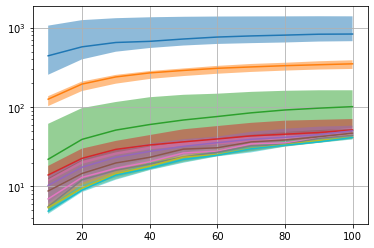

In [69]:
med_ts = np.median(all_timescales, axis=0)
lb_ts = np.quantile(all_timescales, q = 0.025, axis=0)
ub_ts = np.quantile(all_timescales, q = 0.975,axis=0)

fig, ax = plt.subplots(1)
for its_idx in range(num_its):
    ax.fill_between(lags, lb_ts[:, its_idx], ub_ts[:, its_idx], alpha=0.5)
    ax.plot(lags, med_ts[:, its_idx])
ax.set_yscale('log')
ax.grid()

In [71]:
all_vamps.shape

(7, 10, 3, 9)

In [75]:
med_vamps= np.median(all_vamps, axis=0)
lb_vamps = np.quantile(all_vamps, q = 0.025, axis=0)
ub_vamps = np.quantile(all_vamps, q = 0.975,axis=0)

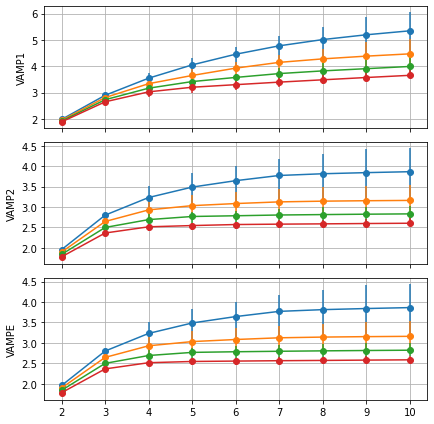

In [91]:
fig, axes = plt.subplots(num_vamp_methods, sharex=True, sharey=False, figsize=(6, 6))
[bs_idx, lag_idx, meth_idx, k_idx]

for meth_idx in range(num_vamp_methods):
    ax = axes[meth_idx]
    for lag_idx in range(0, num_lags,3 ):
        yerr = (med_vamps[lag_idx, meth_idx, :]-lb_vamps[lag_idx, meth_idx, :], ub_vamps[lag_idx, meth_idx, :]-med_vamps[lag_idx, meth_idx, :])
        ax.errorbar(vamp_ks, med_vamps[lag_idx, meth_idx, :], yerr=yerr, marker='o')
    ax.set_ylabel(vamp_methods[meth_idx])
    ax.grid()
plt.tight_layout()